<a href="https://colab.research.google.com/github/TarekAzzouni/Baterries-ML-Lithium-Ions-01/blob/main/Data_Driven_model_for_HNEI_DATASET_(_Machine_learning_part).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of the dataset : 

A batch of fifty-one 18650-format lithium ion cells was purchased from a commercial vendor. These cells were manufactured by LG Chemical Limited, (Seoul, Korea), under the model denomination “ICR18650 C2” and intended for notebook PC applications. The negative electrode (NE) was made of a graphitic intercalation compound (GIC), while the positive electrode (PE) was a blend of LiCoO2 (LCO) and LiNi4Co4Mn2O2 (NMC). The electrolyte composition was not disclosed. The recommended charge cut-off voltage was 4.30 V (associated with a 50 mA cut-off current). The recommended charge rate was C/2 and the maximum charge rate was 1 C. The recommended discharge cut-off voltage was 3.00 V and the maximum discharge rate was 2 C at ambient temperatures (5 to 45 °C). The nominal capacity was 2800 mAh and the maximum weight was 50 grams. The calculated energy density was approximately 208 Wh/kg classifying it as a high-energy cell by current standards.

# Packages 

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from scipy import stats

import tensorflow as tf
import matplotlib.pyplot as plt

import io
import requests


from warnings import simplefilter
import warnings
# ignore all warnings
simplefilter(action='ignore')




# Reading Data & Data leaning / processing 


In [2]:
url="https://www.batteryarchive.org/data/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a_timeseries.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
df_0 = df.replace(to_replace = np.nan, value =25)

In [4]:
df_0

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,3.001400e+01,1.0,0.000,3.779,0.0,0.000,0.0,0.000,25.0,25.0
1,2013-05-22 11:47:26,5.999900e+01,1.0,0.000,3.779,0.0,0.000,0.0,0.000,25.0,25.0
2,2013-05-22 11:47:33,6.729400e+01,1.0,-1.398,3.670,0.0,0.001,0.0,0.005,25.0,25.0
3,2013-05-22 11:47:41,7.430300e+01,1.0,-1.398,3.664,0.0,0.004,0.0,0.015,25.0,25.0
4,2013-05-22 11:47:48,8.131000e+01,1.0,-1.399,3.659,0.0,0.006,0.0,0.025,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...
651026,2015-03-31 11:35:17,1.627613e+07,1113.0,-0.052,3.794,0.0,0.989,0.0,3.785,25.0,25.0
651027,2015-03-31 11:35:47,1.627616e+07,1113.0,-0.051,3.794,0.0,0.989,0.0,3.787,25.0,25.0
651028,2015-03-31 11:36:17,1.627619e+07,1113.0,-0.052,3.794,0.0,0.990,0.0,3.789,25.0,25.0
651029,2015-03-31 11:36:47,1.627622e+07,1113.0,-0.051,3.794,0.0,0.990,0.0,3.790,25.0,25.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651031 entries, 0 to 651030
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Date_Time                    651031 non-null  object 
 1   Test_Time (s)                651031 non-null  float64
 2   Cycle_Index                  651031 non-null  float64
 3   Current (A)                  651031 non-null  float64
 4   Voltage (V)                  651031 non-null  float64
 5   Charge_Capacity (Ah)         651031 non-null  float64
 6   Discharge_Capacity (Ah)      651031 non-null  float64
 7   Charge_Energy (Wh)           651031 non-null  float64
 8   Discharge_Energy (Wh)        651031 non-null  float64
 9   Environment_Temperature (C)  0 non-null       float64
 10  Cell_Temperature (C)         0 non-null       float64
dtypes: float64(10), object(1)
memory usage: 54.6+ MB


In [6]:
#new_df = df_0[df['Cycle_Index'] < 2 ]

In [7]:
#new_df

In [8]:
Train = df_0[df_0['Cycle_Index'] == 2 ]

In [9]:
Train.shape

(2603, 11)

In [10]:
# Test = df_0[df_0['Cycle_Index'] == 1 ]

In [11]:
#Test.shape

In [12]:
Train_1 = Train.drop(['Test_Time (s)','Environment_Temperature (C)','Cell_Temperature (C)','Date_Time','Cycle_Index'],axis=1)

In [13]:
#Test_1 = Test.drop(['Test_Time (s)','Environment_Temperature (C)','Cell_Temperature (C)'],axis=1)

# Feature selection can be done in multiple ways but there are broadly 2 categories of it:



1.   Correlation Coefficient ( filter Method )
2.   Wrapper Methods (if we can get the tangent and set it as target we can you this operation )


## 1/ Correlation Coefficient 
description : Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that the good variables are highly correlated with the target. Furthermore, variables should be correlated with the target but should be uncorrelated among themselves.

We need to set an absolute value, say 0.5 as the threshold for selecting the variables. If we find that the predictor variables are correlated among themselves, we can drop the variable which has a lower correlation coefficient value with the target variable. We can also compute multiple correlation coefficients to check whether more than two variables are correlated to each other. This phenomenon is known as multicollinearity.

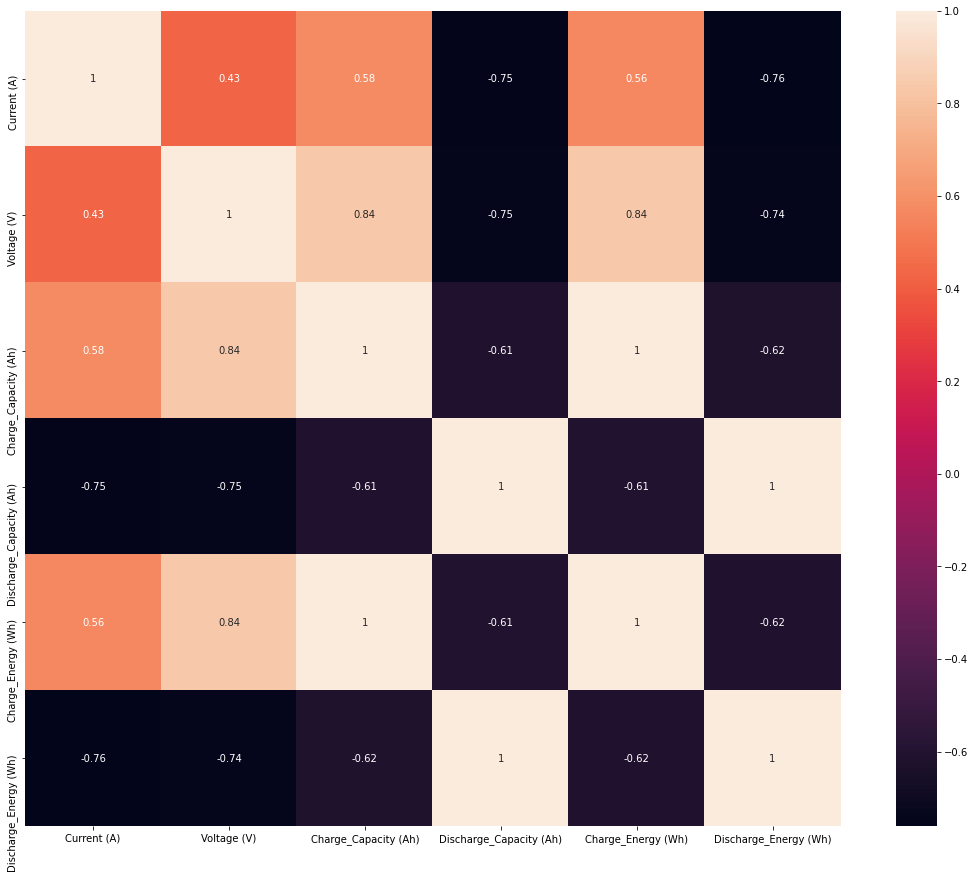

In [14]:
plt.subplots(figsize=(20,15))
cor = Train_1.corr()
sns.heatmap(cor, annot = True,square=True)

In [15]:

#Correlation with output variable
cor_target = abs(cor["Charge_Capacity (Ah)"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Current (A)                0.575478
Voltage (V)                0.837349
Charge_Capacity (Ah)       1.000000
Discharge_Capacity (Ah)    0.614575
Charge_Energy (Wh)         0.999828
Discharge_Energy (Wh)      0.622234
Name: Charge_Capacity (Ah), dtype: float64

Interpretation of the correlation heatmap : 
As we set the charge capacity as a correlation target and we say what are the features that influence the Charge Capacity: 
those features are : 


*   Test time  & The Voltage (V) have a high correlation of 0.978678 and 0,940138 respectively we can see that they increase at the same time (verification in Data visualization part ) 
*   Charge_Energy (Wh) has a highest correlation. 
     

*   Discharge Energy (Wh) and Discharge Capacity (Ah) have a negative correlation ( see the heat map and in the data visualization part) which means that : one variable increases as the other decreases, and vice versa . 





## 2/ Wrapper Methods
Description : Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

*Forward Feature Selection :* This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved

link 1: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html?highlight=sequentialfeatureselector#sklearn.feature_selection.SequentialFeatureSelector

link 2 : https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

# Data visualization over the charge capacity 

In [16]:
graph1 = df_0[df_0['Cycle_Index'] == 1 ]

In [17]:
graph2 = df_0[df_0['Cycle_Index'] == 450 ]

In [18]:
graph3 = df_0[df_0['Cycle_Index'] == 1100]

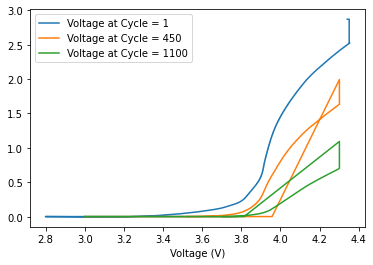

In [40]:
ax = plt.gca()

graph1.plot(kind='line',x='Voltage (V)',y='Charge_Capacity (Ah)',ax=ax, label='Voltage at Cycle = 1')
graph2.plot(kind='line',x='Voltage (V)',y='Charge_Capacity (Ah)',ax=ax, label='Voltage at Cycle = 450')
graph3.plot(kind='line',x='Voltage (V)',y='Charge_Capacity (Ah)',ax=ax, label='Voltage at Cycle = 1100')

#ax.set_ylabel('Charge_Capacity (Ah)',color='navy',fontsize=17)
plt.title("")

plt.show()

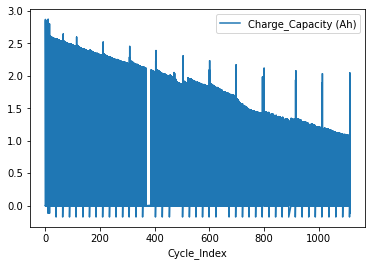

In [20]:
ax = plt.gca()

df_0.plot(kind='line',x='Cycle_Index',y='Charge_Capacity (Ah)',ax=ax, label='Charge_Capacity (Ah)')
#graph2.plot(kind='line',x='Charge_Capacity (Ah)',y='Voltage (V)',ax=ax, label='Voltage at Cycle = 450')
#graph3.plot(kind='line',x='Charge_Capacity (Ah)',y='Voltage (V)',ax=ax, label='Voltage at Cycle = 1100')

#ax.set_ylabel('Charge_Capacity (Ah)',color='navy',fontsize=17)
plt.title("")

plt.show()

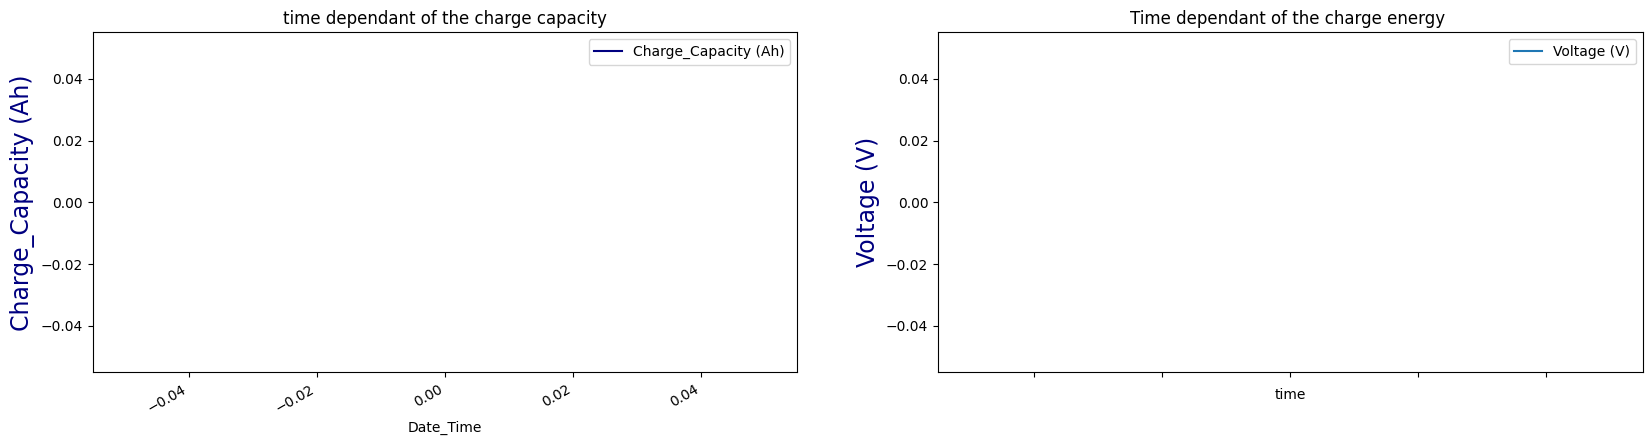

In [21]:
import datetime as dt

graph1['Date_Time']= pd.to_datetime(Train['Date_Time'],format='%Y-%m-%d %H:%M:%S')

df_gen=graph1.groupby('Date_Time').sum().reset_index()
df_gen['time']=df_gen['Date_Time'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# Charge capacity plot
df_gen.plot(x='Date_Time',y='Charge_Capacity (Ah)',color='navy',ax=ax[0])
# Charge energy plot
df_gen.set_index('time').drop('Date_Time',1)[['Voltage (V)']].plot(ax=ax[1])

ax[0].set_title('time dependant of the charge capacity',)
ax[1].set_title('Time dependant of the charge energy ')
ax[0].set_ylabel('Charge_Capacity (Ah)',color='navy',fontsize=17)
ax[1].set_ylabel('Voltage (V)', color = 'navy',fontsize=17)
plt.show()

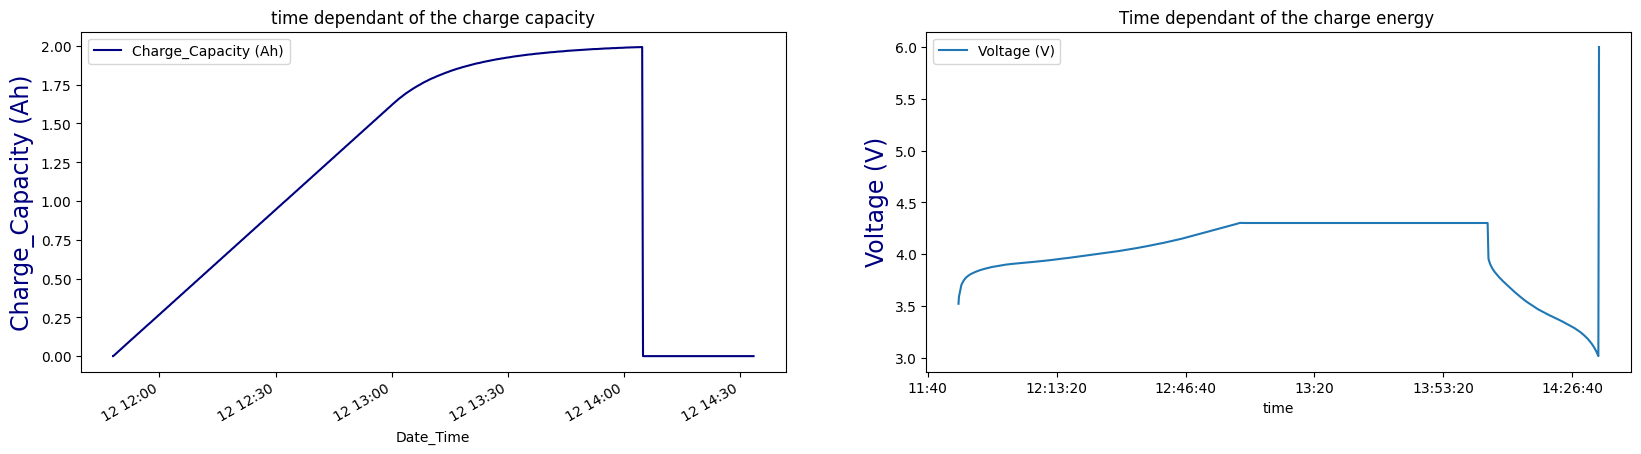

In [22]:
import datetime as dt

graph2['Date_Time']= pd.to_datetime(graph2['Date_Time'],format='%Y-%m-%d %H:%M')

df_gen=graph2.groupby('Date_Time').sum().reset_index()
df_gen['time']=df_gen['Date_Time'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# Charge capacity plot
df_gen.plot(x='Date_Time',y='Charge_Capacity (Ah)',color='navy',ax=ax[0])
# Charge energy plot
df_gen.set_index('time').drop('Date_Time',1)[['Voltage (V)']].plot(ax=ax[1])

ax[0].set_title('time dependant of the charge capacity',)
ax[1].set_title('Time dependant of the charge energy ')
ax[0].set_ylabel('Charge_Capacity (Ah)',color='navy',fontsize=17)
ax[1].set_ylabel('Voltage (V)', color = 'navy',fontsize=17)
plt.show()

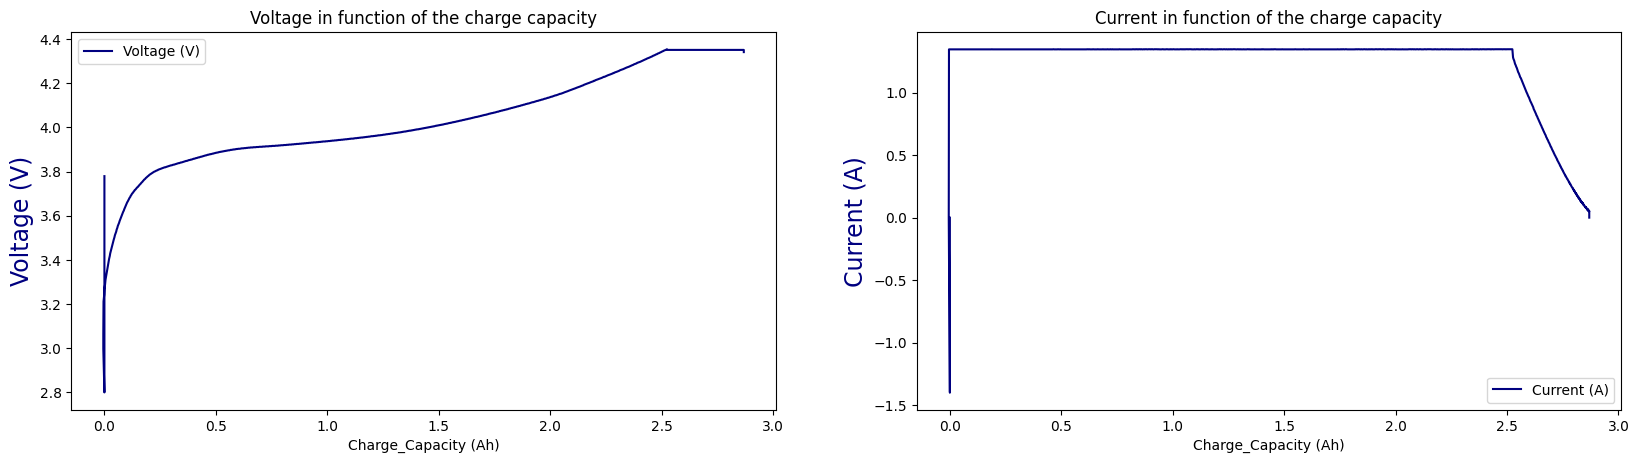

In [23]:
fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# Charge capacity plot
graph1.plot(x='Charge_Capacity (Ah)',y='Voltage (V)',color='navy',ax=ax[0])
# Charge energy plot
graph1.plot(x='Charge_Capacity (Ah)',y='Current (A)',color='navy',ax=ax[1])
# Charge energy plot

ax[0].set_title('Voltage in function of the charge capacity',)
ax[1].set_title('Current in function of the charge capacity')
ax[0].set_ylabel('Voltage (V)',color='navy',fontsize=17)
ax[1].set_ylabel('Current (A)', color = 'navy',fontsize=17)
plt.show()

this is the evidence of the non correlation between the current and charge capacity. 
Therefor we can see the relationship between voltage and the charge capacity 

In [24]:
#Test.shape

observation of the cycles on the battery. 

# Neural Network model 

## 1/ Test diffirent models of machine learning for a regression.

In [25]:
Train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 1956 to 4558
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Current (A)              2603 non-null   float64
 1   Voltage (V)              2603 non-null   float64
 2   Charge_Capacity (Ah)     2603 non-null   float64
 3   Discharge_Capacity (Ah)  2603 non-null   float64
 4   Charge_Energy (Wh)       2603 non-null   float64
 5   Discharge_Energy (Wh)    2603 non-null   float64
dtypes: float64(6)
memory usage: 222.4 KB


In [26]:
#Train_1['charge_capacity_per'] = (Train_1['Charge_Capacity (Ah)']/ 
#                                  Train_1['Charge_Capacity (Ah)'].sum())*100000 

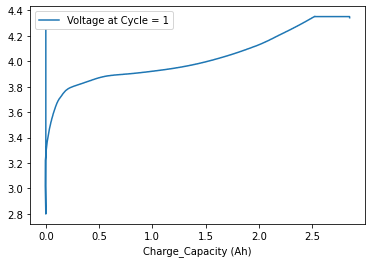

In [27]:
ax = plt.gca()

Train_1.plot(kind='line',x='Charge_Capacity (Ah)',y='Voltage (V)',ax=ax, label='Voltage at Cycle = 1')

#ax.set_ylabel('Charge_Capacity (Ah)',color='navy',fontsize=17)
plt.title("")

plt.show()

In [28]:
#Test['charge_capacity_per'] = (Test['Charge_Capacity (Ah)']/ 
                               #   Test['Charge_Capacity (Ah)'].sum())*100000 

In [29]:
Train_1

,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
1956,-1.399,4.246,0.000,0.000,0.000,0.000
1957,-1.398,4.239,0.000,0.002,0.000,0.011
1958,-1.398,4.233,0.000,0.005,0.000,0.023
1959,-1.398,4.229,0.000,0.008,0.000,0.034
1960,-1.399,4.225,0.000,0.010,0.000,0.046
...,...,...,...,...,...,...
4554,0.000,4.342,2.854,0.000,11.485,0.000
4555,0.000,4.342,2.854,0.000,11.485,0.000
4556,0.000,4.342,2.854,0.000,11.485,0.000
4557,0.000,4.342,2.854,0.000,11.485,0.000


### The logic behind the charge capacity percentage 

Once we have tried the LTSM ( see below ) which is a forcasting model, we thought that it would be better to creat a new column that will look like the SOC. so as in the Data vizualization part, the bihaviour of the CC is similar to the SOC. 

### Machine Learning model Supervised model 

In [30]:
Train_1.columns

Index(['Current (A)', 'Voltage (V)', 'Charge_Capacity (Ah)',
       'Discharge_Capacity (Ah)', 'Charge_Energy (Wh)',
       'Discharge_Energy (Wh)'],
      dtype='object')

In [31]:
Col_feature = ["Voltage (V)","Discharge_Capacity (Ah)","Charge_Energy (Wh)","Current (A)"]
Col_target = ["Charge_Capacity (Ah)"]

In [32]:
feature = Train_1[Col_feature]
target = Train_1[Col_target]

In [33]:
#Split training dataset into independent and dependent varibales
train_X = Train_1[feature.columns]
y = Train_1[target.columns]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Train_1, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(2082, 6) (2082, 1)
(521, 6) (521, 1)


In [35]:
#Split testing dataset into independent and dependent varibales
#test_X = Test[feature.columns]
#test_y = Test[target.columns]

In [36]:
from sklearn.linear_model import Lasso , Ridge
from sklearn.ensemble import RandomForestRegressor,  ExtraTreesRegressor , GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR

In [37]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [39]:
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing, model_selection, metrics
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE_Score"] = sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    model_data.append(curr_model_data)

[22:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model_data

In [ ]:
models


In [ ]:
Train_2 = pd.DataFrame(model_data)

In [ ]:
Train_2.plot(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' , 'Test_RMSE_Score'], kind="bar" , title = 'R2 Score Results' , figsize= (10,10)) ;

In [ ]:
Train_2

### Evaluating Machine Learning Models using Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
# R2 score on training set with tuned parameters

grid_search.best_estimator_.score(X_train,y_train)

In [ ]:
# R2 score on test set with tuned parameters
grid_search.best_estimator_.score(X_test,y_test)

exploring the random forest ML method prediction.

In this part we are going to go deeper in the Random forest method as we saw that it gave us a Test R² score of : 0.9472581168453291 

In [ ]:

# test regression dataset
from sklearn.datasets import make_regression
# define dataset
train_X, train_y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=2)
# summarize the dataset
print(train_X.shape, train_y.shape)

In [ ]:
# evaluate random forest ensemble for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
# define dataset
train_X, train_y= make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=2)
# define the model
model = RandomForestRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In this case, we can see the random forest ensemble with default hyperparameters achieves a MAE of about 90.